# Part 1 - MNIST

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install scikit-learn==0.21.* skorch

     |████████████████████████████████| 102kB 4.6MB/s 


## Explore data

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from urllib import request

In [8]:
def download_mnist(dataset_dir=Path('data')):
    dataset_dir.mkdir(exist_ok=True)
    mnist_data = dataset_dir / 'mnist.npz'
    url = 'https://github.com/thomasjpfan/skorch_talk/blob/master/data/mnist.npz?raw=true'
    if not mnist_data.exists():
        print("Starting to download data...")
        data = request.urlopen(url, timeout=15).read()
        with open(mnist_data, 'wb') as f:
            f.write(data)
    print("Data has been downloaded to {}.".format(dataset_dir))
    
download_mnist()

Starting to download data...
Data has been downloaded to data.


In [0]:
mnist = np.load('data/mnist.npz', allow_pickle=True)

In [10]:
X = mnist['data'].astype('float32')
y = mnist['target'].astype('int64')

print(X.shape, y.shape)

(70000, 784) (70000,)


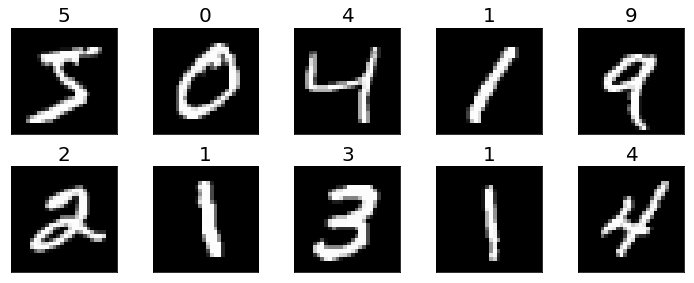

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.patch.set_alpha(0)
Path('images').mkdir(exist_ok=True)

for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(y[idx], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('images/mnist_example.png')

## Simple Neutral Model

In [0]:
import torch.nn as nn

class SimpleFeedforward(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.module = nn.Sequential(
            nn.Linear(784, 98),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(98, 10)
        )
    def forward(self, X):
        return self.module(X)

In [0]:
from sklearn.model_selection import train_test_split

X_scaled = X / X.max()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42)

In [0]:
from skorch import NeuralNet

net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda', # comment out to run on cpu
)

In [17]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5782        0.3032  1.0128
      2        0.3196        0.2418  0.9599
      3        0.2668        0.1862  0.9304
      4        0.2378        0.1770  0.8558
      5        0.2178        0.1520  0.8517
      6        0.2020        0.1395  0.8458
      7        0.1925        0.1428  0.8413
      8        0.1820        0.1280  0.8512
      9        0.1739        0.1203  0.8586
     10        0.1695        0.1191  0.8671


In [18]:
net.set_params(max_epochs=5)
_ = net.partial_fit(X_train, y_train)

     11        0.1637        0.1173  0.8628
     12        0.1585        0.1176  0.8481
     13        0.1507        0.1227  0.8377
     14        0.1518        0.1213  0.8660
     15        0.1485        0.1170  0.8635


## History

In [19]:
len(net.history)

15

In [20]:
net.history[-1, 'valid_loss']

0.1169985074769883

In [21]:
net.history[-2:, 'train_loss']

[0.15179336678414118, 0.14848752582640876]

## Callbacks

### EpochScoring

In [22]:
y_pred = net.predict(X_test)
print(y_pred.shape)
print(y_pred[0, :])

(17500, 10)
[-3.4358888 -2.0577073  3.7705815  6.779972  -9.432296   6.362274
 -7.0874496 -6.521524  13.821182  -2.024027 ]


In [23]:
def accuracy_argmax(y_true, y_pred):
    return np.mean(y_true == np.argmax(y_pred, -1))

print('test accuracy:', accuracy_argmax(y_test, y_pred))

test accuracy: 0.9639428571428571


In [0]:
from sklearn.metrics import make_scorer
from skorch.callbacks import EpochScoring

accuracy_argmax_scorer = make_scorer(accuracy_argmax)

epoch_acc = EpochScoring(
    accuracy_argmax_scorer,
    name='valid_acc',
    lower_is_better=False)

In [0]:
net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda',
    callbacks=[epoch_acc]
)

In [26]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5718       0.9059        0.3164  0.8544
      2        0.3157       0.9167        0.2671  0.8785
      3        0.2666       0.9476        0.1747  0.9770
      4        0.2328       0.9462        0.1766  0.8530
      5        0.2150       0.9544        0.1477  0.8515
      6        0.1988       0.9560        0.1424  0.8406
      7        0.1880       0.9617        0.1306  0.8444
      8        0.1827       0.9634        0.1251  0.8464
      9        0.1733       0.9594        0.1353  0.8669
     10        0.1672       0.9665        0.1146  0.8480


## Integration with sklearn

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [0]:
pipe = Pipeline([
    ('min_max', MinMaxScaler()),
    ('net', net)
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
_ = pipe.fit(X_train, y_train)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5807       0.8950        0.3468  0.8920
      2        0.3228       0.9297        0.2228  0.8956
      3        0.2658       0.9406        0.1939  0.8913
      4        0.2445       0.9470        0.1662  0.8910
      5        0.2205       0.9536        0.1539  0.8898
      6        0.2066       0.9570        0.1403  0.8917
      7        0.1953       0.9524        0.1543  0.8990
      8        0.1887       0.9593        0.1346  0.8918
      9        0.1772       0.9644        0.1187  0.8893
     10        0.1741       0.9634        0.1198  0.9026


In [0]:
from sklearn.model_selection import GridSearchCV

pipe.set_params(net__verbose=0)
param_grid = {
    'net__module__dropout': [0.2, 0.5, 0.8]
}

gs = GridSearchCV(pipe, param_grid, 
                  scoring=accuracy_argmax_scorer, 
                  cv=3, verbose=3)

In [31]:
_ = gs.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ net__module__dropout=0.2, score=0.965, total=  10.0s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] ............ net__module__dropout=0.2, score=0.963, total=   9.8s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.9s remaining:    0.0s


[CV] ............ net__module__dropout=0.2, score=0.969, total=   9.9s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.962, total=   9.9s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.955, total=   9.9s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.966, total=  10.0s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.938, total=   9.8s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.932, total=   9.7s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.943, total=   9.8s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min finished


In [32]:
print("best score:", gs.best_score_)
print("best_params", gs.best_params_)

best score: 0.9658714285714286
best_params {'net__module__dropout': 0.2}
